In [1]:
!unzip '/content/drive/MyDrive/plaintext_data.zip'

Archive:  /content/drive/MyDrive/plaintext_data.zip
   creating: plaintext_data/
  inflating: __MACOSX/._plaintext_data  
  inflating: plaintext_data/1691_Radiology.txt  
  inflating: __MACOSX/plaintext_data/._1691_Radiology.txt  
  inflating: plaintext_data/2828_Neurology.txt  
  inflating: __MACOSX/plaintext_data/._2828_Neurology.txt  
  inflating: plaintext_data/3340_General Medicine.txt  
  inflating: __MACOSX/plaintext_data/._3340_General Medicine.txt  
  inflating: plaintext_data/3473_Gastroenterology.txt  
  inflating: __MACOSX/plaintext_data/._3473_Gastroenterology.txt  
  inflating: plaintext_data/3480_Gastroenterology.txt  
  inflating: __MACOSX/plaintext_data/._3480_Gastroenterology.txt  
  inflating: plaintext_data/2882_Neurology.txt  
  inflating: __MACOSX/plaintext_data/._2882_Neurology.txt  
  inflating: plaintext_data/3218_General Medicine.txt  
  inflating: __MACOSX/plaintext_data/._3218_General Medicine.txt  
  inflating: plaintext_data/3552_Gastroenterology.txt  
  i

# Importing libraries

In [43]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import time
import glob
import math
import string
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from wordcloud import WordCloud
from prettytable import PrettyTable

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Conv1D, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential

# Import Data

In [3]:
cols = ['text']
plaintext_files = pd.DataFrame()

address = glob.glob('/content/plaintext_data/*.txt')
count = 0

for i in address:
  with open(i, 'rb') as data_of_files:
    data = pd.read_csv(data_of_files, sep='\t', header=None, names=cols)
    plaintext_files = pd.concat([plaintext_files, data['text']], axis=0)
    count += 1
    if count==493:
      break

plaintext_files = plaintext_files.rename(columns={0:'text'})
plaintext_files.head(10)

,text
0,ADMISSION DIAGNOSES:
1,"1. Pneumonia, likely secondary to aspiration."
2,2. Chronic obstructive pulmonary disease (COP...
3,3. Systemic inflammatory response syndrome.
4,4. Hyperglycemia.
5,DISCHARGE DIAGNOSES:
6,1. Aspiration pneumonia.
7,2. Aspiration disorder in setting of severe c...
8,3. Chronic obstructive pulmonary disease (COP...
9,4. Acute respiratory on chronic respiratory f...


Removing punctuation from the text

In [4]:
epunctuations = string.punctuation
puntuation_list = epunctuations
def cleaning_punct(text):
  translator = str.maketrans('', '', puntuation_list)
  return text.translate(translator)

In [5]:
plaintext_files['text'] = plaintext_files['text'].apply(lambda x: cleaning_punct(x))

Removing special characters

In [6]:
def cleaning_chars(text):
  text = re.sub(r'#([^\s]+)', r'\1', text)
  return text

In [7]:
plaintext_files['text'] = plaintext_files['text'].apply(lambda x: cleaning_chars(x))

Converting sentences of plain text into words in each row

In [8]:
plaintext_files = plaintext_files.text.str.split(expand=True).stack()
plaintext_files

0   0    ADMISSION
    1    DIAGNOSES
1   0            1
    1    Pneumonia
    2       likely
           ...    
32  4           at
    5         ABCD
    6        after
    7      cardiac
    8         cath
Length: 200071, dtype: object

Importing the ground truth annotation file

In [9]:
ground_truth = pd.read_csv('/content/drive/MyDrive/ground_truth_annotation_file.csv')
ground_truth.head(10)

,file,start,end,text,class
0,12_Neurology.txt,1935,1939,head,Others
1,12_Neurology.txt,1947,1967,left caudate nucleus,Others
2,12_Neurology.txt,2008,2016,arterial,Others
3,12_Neurology.txt,2041,2044,MCA,Others
4,12_Neurology.txt,2366,2369,MCA,Others
5,12_Neurology.txt,2433,2436,MCA,Others
6,12_Neurology.txt,2539,2542,MCA,Others
7,12_Neurology.txt,2608,2611,MCA,Others
8,12_Neurology.txt,1244,1265,right nasolabial fold,Others
9,12_Neurology.txt,3365,3369,neck,Others


Storing text to a list

In [10]:
list1 = list(ground_truth['text'])
list1[:10]

['head',
 'left caudate nucleus',
 'arterial',
 'MCA',
 'MCA',
 'MCA',
 'MCA',
 'MCA',
 'right nasolabial fold',
 'neck']

Creating a dataframe with the ground truth labels

In [11]:
processed_data = pd.DataFrame({
    'Sentence#': plaintext_files.index.get_level_values(0) + 1,
    'Word': plaintext_files.values,
    'Tag': plaintext_files.map(dict(zip(ground_truth.text, ground_truth['class']))).fillna(0).values
})

In [12]:
processed_data.head(10)

,Sentence#,Word,Tag
0,1,ADMISSION,0
1,1,DIAGNOSES,0
2,2,1,0
3,2,Pneumonia,0
4,2,likely,0
5,2,secondary,0
6,2,to,0
7,2,aspiration,Disease_Syndrome
8,3,2,0
9,3,Chronic,0


# Exploratory Data Analysis

Top 5 records of the processed data

In [13]:
processed_data.head(5)

,Sentence#,Word,Tag
0,1,ADMISSION,0
1,1,DIAGNOSES,0
2,2,1,0
3,2,Pneumonia,0
4,2,likely,0


Last 5 records of the processed data

In [14]:
processed_data.tail(5)

,Sentence#,Word,Tag
200066,33,at,0
200067,33,ABCD,0
200068,33,after,0
200069,33,cardiac,Others
200070,33,cath,0


Features of the data

In [15]:
processed_data.columns

Index(['Sentence#', 'Word', 'Tag'], dtype='object')

Length of the data

In [16]:
len(processed_data)

200071

Total shape of the data

In [17]:
processed_data.shape

(200071, 3)

Describing the data

In [18]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200071 entries, 0 to 200070
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentence#  200071 non-null  int64 
 1   Word       200071 non-null  object
 2   Tag        200071 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


In [19]:
processed_data.describe()

,Sentence#
count,200071.000000
mean,15.077368
std,10.655474
min,1.000000
25%,6.000000
50%,12.000000
75%,21.000000
max,53.000000


Checking the null values in the data

In [20]:
np.sum(processed_data.isnull().any(axis=1))

0

Distribution of rows in each class

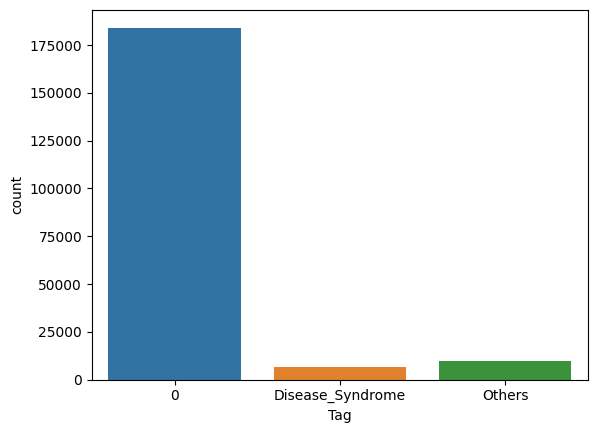

In [21]:
sns.countplot(data=processed_data, x='Tag')
plt.show()

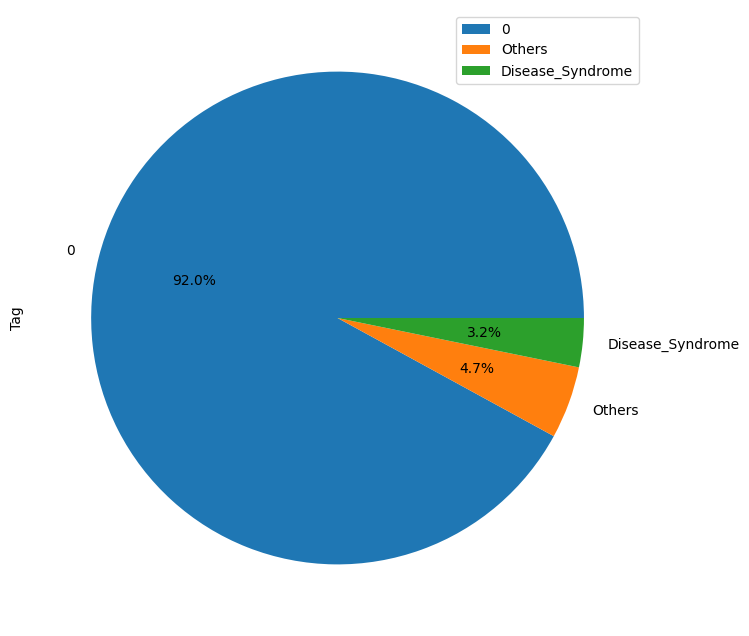

In [22]:
processed_data['Tag'].value_counts().head(7).plot(kind='pie', autopct='%1.1f%%', figsize=(8,8)).legend()

In [23]:
processed_data['Tag'].value_counts()

0                   184143
Others                9500
Disease_Syndrome      6428
Name: Tag, dtype: int64

Tag - Others

In [24]:
processed_data.loc[processed_data['Tag'] == 'Others', 'Word'].head()

11    pulmonary
12      disease
19     syndrome
22    DISCHARGE
29     disorder
Name: Word, dtype: object

Tag - Disease Syndrome

In [25]:
processed_data.loc[processed_data['Tag'] == 'Disease_Syndrome', 'Word'].head()

7     aspiration
13          COPD
26     pneumonia
43          COPD
76    aspiration
Name: Word, dtype: object

Tag - 0

In [26]:
processed_data.loc[processed_data['Tag'] == 0, 'Word'].head()

0    ADMISSION
1    DIAGNOSES
2            1
3    Pneumonia
4       likely
Name: Word, dtype: object

# Data Preparation

Converting data in lower case

In [27]:
processed_data['Word'] = processed_data['Word'].str.lower()

Applying stemming

In [28]:
st = nltk.PorterStemmer()
def stemming_on_text(processed_data):
  text = [st.stem(word) for word in processed_data]
  return text
processed_data['Word'] = processed_data['Word'].apply(lambda x: stemming_on_text(x))

In [29]:
processed_data

,Sentence#,Word,Tag
0,1,"[a, d, m, i, s, s, i, o, n]",0
1,1,"[d, i, a, g, n, o, s, e, s]",0
2,2,[1],0
3,2,"[p, n, e, u, m, o, n, i, a]",0
4,2,"[l, i, k, e, l, y]",0
...,...,...,...
200066,33,"[a, t]",0
200067,33,"[a, b, c, d]",0
200068,33,"[a, f, t, e, r]",0
200069,33,"[c, a, r, d, i, a, c]",Others


Applying Lemmatization

In [31]:
nltk.download('wordnet')

lm = nltk.WordNetLemmatizer()
def lemmatize_on_text(processed_data):
  text = [lm.lemmatize(word) for word in processed_data]
  return text
processed_data['Word'] = processed_data['Word'].apply(lambda x: lemmatize_on_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [32]:
processed_data

,Sentence#,Word,Tag
0,1,"[a, d, m, i, s, s, i, o, n]",0
1,1,"[d, i, a, g, n, o, s, e, s]",0
2,2,[1],0
3,2,"[p, n, e, u, m, o, n, i, a]",0
4,2,"[l, i, k, e, l, y]",0
...,...,...,...
200066,33,"[a, t]",0
200067,33,"[a, b, c, d]",0
200068,33,"[a, f, t, e, r]",0
200069,33,"[c, a, r, d, i, a, c]",Others


Filtering Others and Disease_Syndrome

In [33]:
aa = processed_data[processed_data['Tag']=='Others']
bb = processed_data[processed_data['Tag']=='Disease_Syndrome']
processed_data = pd.concat([aa, bb])
processed_data

,Sentence#,Word,Tag
11,3,"[p, u, l, m, o, n, a, r, y]",Others
12,3,"[d, i, s, e, a, s, e]",Others
19,4,"[s, y, n, d, r, o, m, e]",Others
22,6,"[d, i, s, c, h, a, r, g, e]",Others
29,8,"[d, i, s, o, r, d, e, r]",Others
...,...,...,...
199775,7,"[h, y, p, e, r, t, e, n, s, i, o, n]",Disease_Syndrome
199779,8,"[o, b, e, s, i, t, y]",Disease_Syndrome
199832,18,"[d, i, a, b, e, t, e, s]",Disease_Syndrome
199901,18,"[i, n, f, a, r, c, t, i, o, n]",Disease_Syndrome


Distribution of class

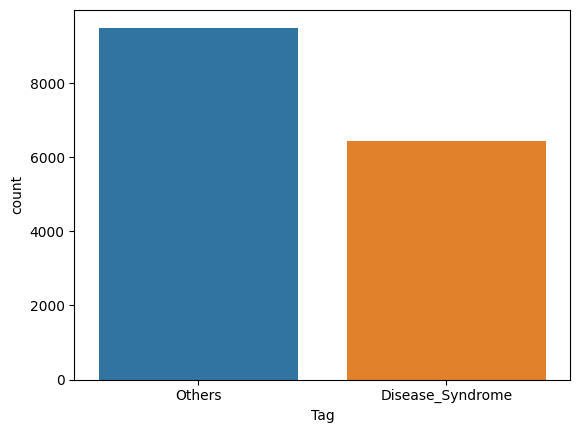

In [34]:
sns.countplot(data=processed_data, x='Tag')
plt.show()

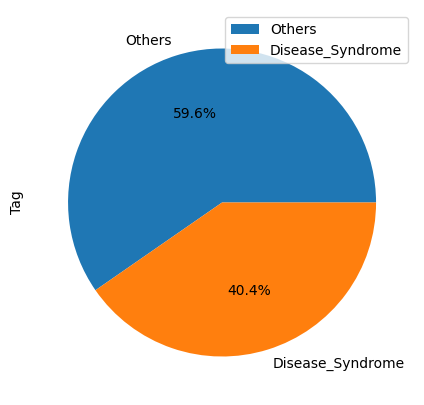

In [35]:
processed_data['Tag'].value_counts().head(7).plot(kind='pie', autopct='%1.1f%%', figsize=(5,5)).legend()

Encoding the Tags

In [36]:
processed_data['Tag'] = processed_data['Tag'].replace('Others', 1)
processed_data['Tag'] = processed_data['Tag'].replace('Disease_Syndrome', 2)

Input and output features

In [37]:
X = processed_data.Word
Y = processed_data['Tag']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1, 1)

Feature Extraction using Sequence Extractor

In [39]:
max_words = 1500
max_len = 300
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [40]:
sequence_matrix

array([[ 0,  0,  0, ...,  2,  5, 16],
       [ 0,  0,  0, ...,  2,  4,  1],
       [ 0,  0,  0, ...,  7, 12,  1],
       ...,
       [ 0,  0,  0, ...,  8,  1,  4],
       [ 0,  0,  0, ...,  3,  7,  6],
       [ 0,  0,  0, ...,  9, 19, 13]], dtype=int32)

Split data into train and test

In [41]:
X_train, X_test, y_train, y_test = train_test_split(sequence_matrix, Y, test_size=0.3, random_state=2)

# RNN Model

In [42]:
def RNN_Model():
  inputs = Input(name='inputs', shape=[max_len])
  layer = Embedding(max_words, 50, input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256, name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1, name = 'out_layer')(layer)
  model = Model(inputs=inputs, outputs=layer)
  return model

In [44]:
model = RNN_Model()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['acc'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 50)           75000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

Training and Validation

In [45]:
history = model.fit(X_train, y_train, batch_size=500, epochs=20, validation_split=0.1)
print("Training Finished!")

Epoch 1/20
21/21 [==============================] - 34s 1s/step - loss: 0.9690 - acc: 0.5883 - val_loss: 0.6627 - val_acc: 0.6000
Epoch 2/20
21/21 [==============================] - 37s 2s/step - loss: 0.6589 - acc: 0.6147 - val_loss: 0.6713 - val_acc: 0.5318
Epoch 3/20
21/21 [==============================] - 44s 2s/step - loss: 0.6011 - acc: 0.6784 - val_loss: 0.5609 - val_acc: 0.7390
Epoch 4/20
21/21 [==============================] - 41s 2s/step - loss: 0.5672 - acc: 0.7234 - val_loss: 0.5263 - val_acc: 0.7435
Epoch 5/20
21/21 [==============================] - 39s 2s/step - loss: 0.5346 - acc: 0.7455 - val_loss: 0.6121 - val_acc: 0.7291
Epoch 6/20
21/21 [==============================] - 35s 2s/step - loss: 0.5237 - acc: 0.7597 - val_loss: 0.4781 - val_acc: 0.7883
Epoch 7/20
21/21 [==============================] - 43s 2s/step - loss: 0.5041 - acc: 0.7743 - val_loss: 0.4899 - val_acc: 0.7363
Epoch 8/20
21/21 [==============================] - 40s 2s/step - loss: 0.4968 - acc: 0.76

Train and Validation Plots

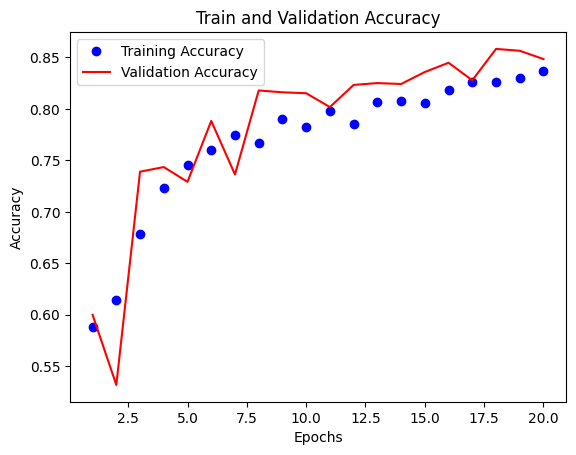

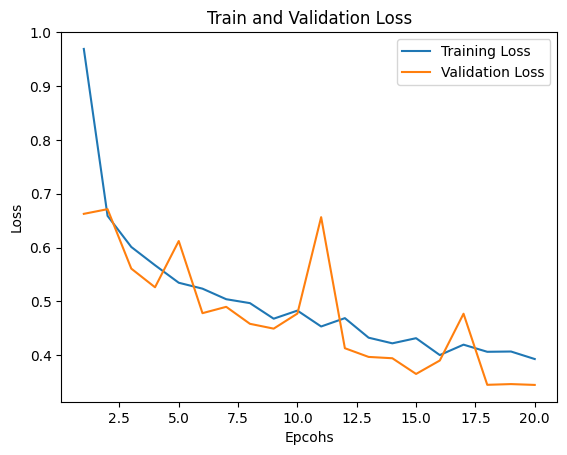

In [47]:
def train_and_validation_plots(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
  plt.title('Train and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Train and Validation Loss')
  plt.xlabel('Epcohs')
  plt.ylabel('Loss')
  plt.legend()

train_and_validation_plots(history)

Highest validation accuracy point

Text(23, 0.8782959771156311, '0.8582')

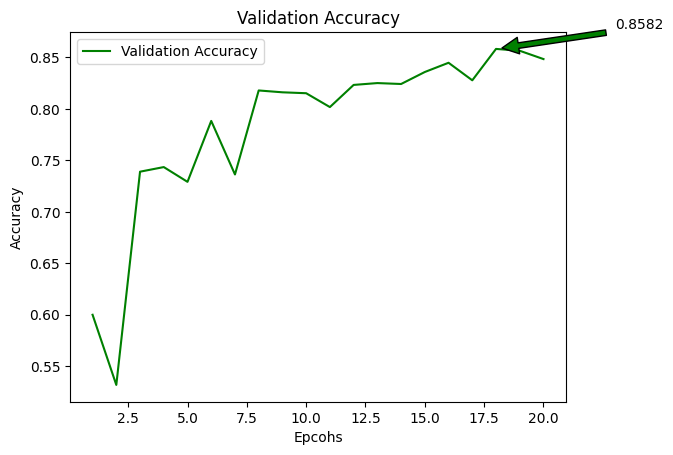

In [48]:
val_acc = history.history['val_acc']
acc = history.history['acc']
epochs = range(1, len(acc)+1)
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epcohs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6], (x_arrow, y_arrow), xytext=(x_arrow+5, y_arrow+0.02), arrowprops=dict(facecolor='green', shrink=0.05))

Accuracy

In [49]:
y_pred1 = model.predict(X_test)
y_pred1 = (y_pred1 > 0.5)
accr = model.evaluate(X_test, y_test)
rnn_acc = accr[1]
print('Test set accuracy ', accr[1])

150/150 [==============================] - 6s 39ms/step - loss: 0.3866 - acc: 0.8251
Test set accuracy  0.8250679969787598


Precision, Recall, F1 score

In [50]:
print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred1)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

           0       0.79      0.96      0.87      2844
           1       0.92      0.62      0.74      1935

    accuracy                           0.83      4779
   macro avg       0.85      0.79      0.81      4779
weighted avg       0.84      0.83      0.82      4779





Confusion Matrix

In [51]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred1)
print(CR)



confusion matrix


[[2737  107]
 [ 729 1206]]


AUC plot

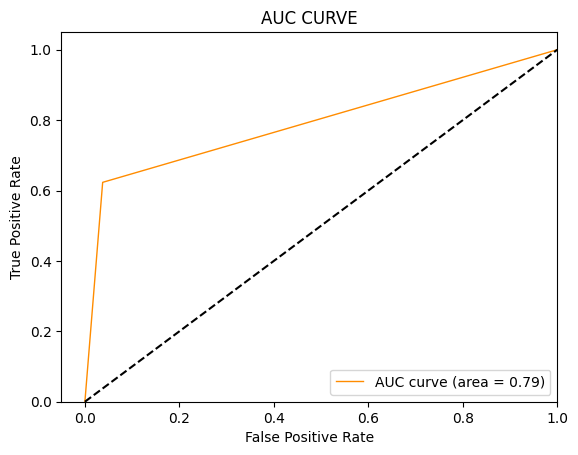

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='AUC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC CURVE')
plt.legend(loc="lower right")
plt.show()

Random Forest Model

In [53]:
RF = RandomForestClassifier()

In [54]:
params = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

Hyperparameter Optimization

In [55]:
Grid_RN = RandomizedSearchCV(estimator = RF, param_distributions = params)
Grid_RN.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [200, 500]})

Best Parameters

In [56]:
Grid_RN.best_params_

{'n_estimators': 500,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'gini'}

Accuracy

In [57]:
RF_R=Grid_RN.predict(X_test)
RF_acc=Grid_RN.score(X_test, y_test)
print('Accuracy score= {:.2f}'.format(Grid_RN.score(X_test, y_test)))

Accuracy score= 0.92


Precision, Recall, F1 score

In [58]:
print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, RF_R)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2844
           1       0.97      0.83      0.89      1935

    accuracy                           0.92      4779
   macro avg       0.93      0.91      0.92      4779
weighted avg       0.93      0.92      0.92      4779





Confusion Matrix

In [59]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, RF_R)
print(CR)



confusion matrix


[[2792   52]
 [ 326 1609]]


AUC plot

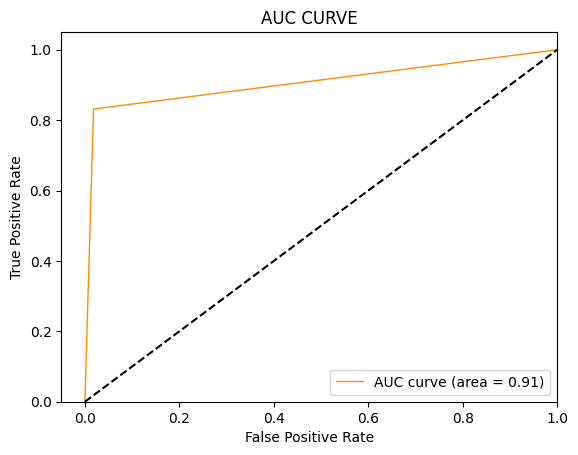

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, RF_R)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='AUC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC CURVE')
plt.legend(loc="lower right")
plt.show()

# Comparison of RNN Model and Random Forest Model

In [61]:
x = PrettyTable()
print('\n')
print("Comparison of RNN and Random Forest Results")
x.field_names = ["Model", "Accuracy"]

x.add_row(["RNN model",  round(rnn_acc,2)])
x.add_row(["Random Forest model", round(RF_acc,3)])

print(x)
print('\n')



Comparison of RNN and Random Forest Results
+---------------------+----------+
|        Model        | Accuracy |
+---------------------+----------+
|      RNN model      |   0.83   |
| Random Forest model |  0.921   |
+---------------------+----------+




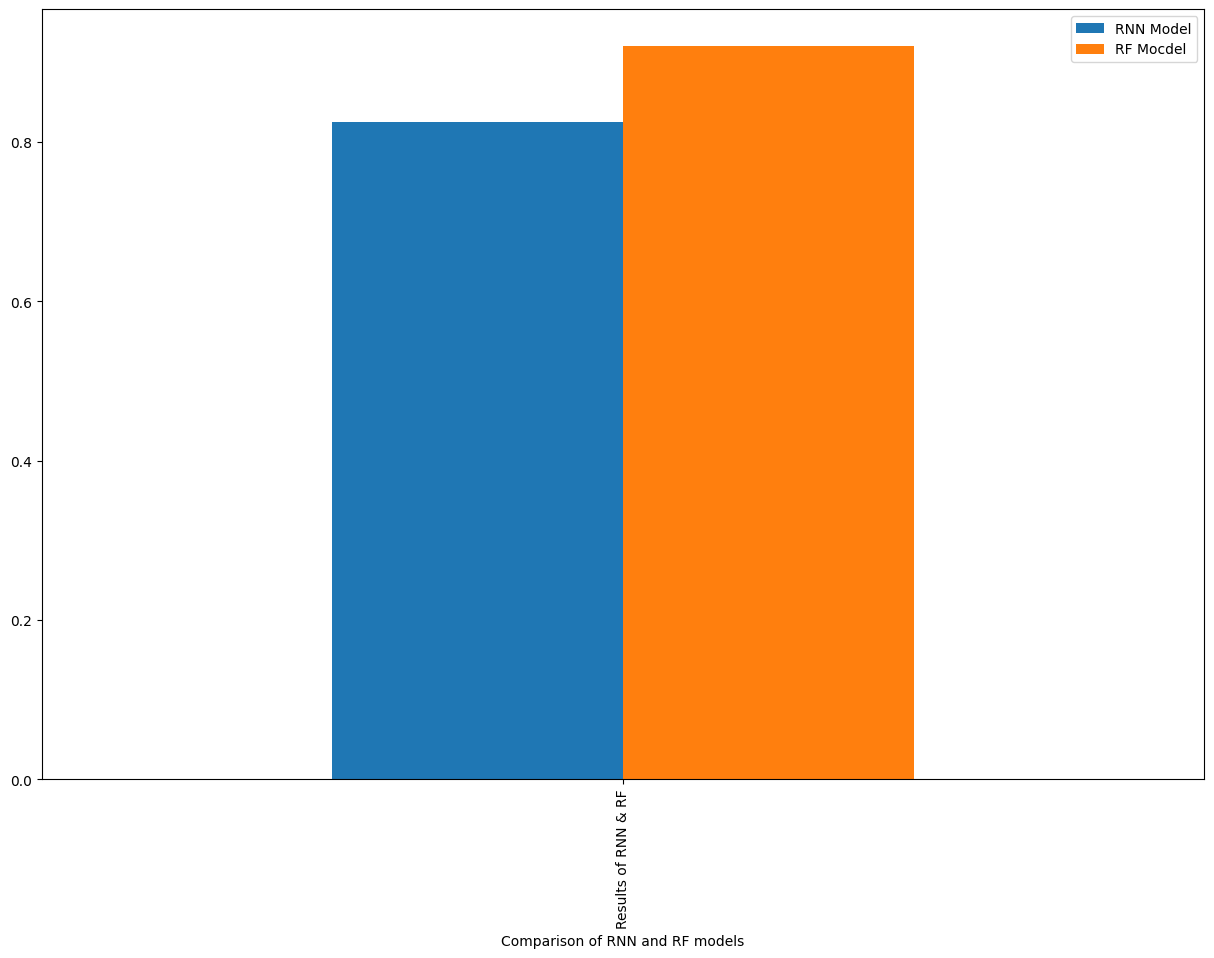

In [62]:
Acc = [['Results of RNN & RF', rnn_acc, RF_acc]]
Acc = pd.DataFrame (Acc, columns = ['Comparison of RNN and RF models','RNN Model', 'RF Mocdel'])
Acc.set_index("Comparison of RNN and RF models",drop=True,inplace=True)
Acc.plot(kind='bar',figsize=(15, 10)).legend(bbox_to_anchor=(1, 1))